In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import copy

plt.rcParams['figure.figsize'] = [12, 8]

---
## Алгоритм Region Growing

In [14]:
def homo_average(img, mask, point, T):
    """Критерий однородности на основе среднего"""
    if np.count_nonzero(mask) == 0:
        return True
    av_val = img[mask > 0].mean()
    return abs(av_val - img[point]) <= T

def homo_median(img, mask, point, T):
    """Критерий однородности на основе медианы"""
    if np.count_nonzero(mask) == 0:
        return True
    median_val = np.median(img[mask > 0])
    return abs(median_val - img[point]) <= T

def homo_std(img, mask, point, T):
    """Критерий на основе стандартного отклонения"""
    if np.count_nonzero(mask) == 0:
        return True
    region = img[mask > 0]
    mean_val, std_val = region.mean(), max(region.std(), 1)
    return abs(img[point] - mean_val) <= T * std_val

def region_growing(image, seed_point, homo_fun, r, T):
    """Алгоритм разрастания регионов"""
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1
    
    while True:
        local_mask = np.zeros(image.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i,j] == 0 and mask[i-r:i+r, j-r:j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        
        if np.count_nonzero(local_mask) == 0:
            break
        mask += local_mask
    
    return mask * 255

---
## Region Growing для выделения газона

Выделение газона: seed=(250, 250), T=10


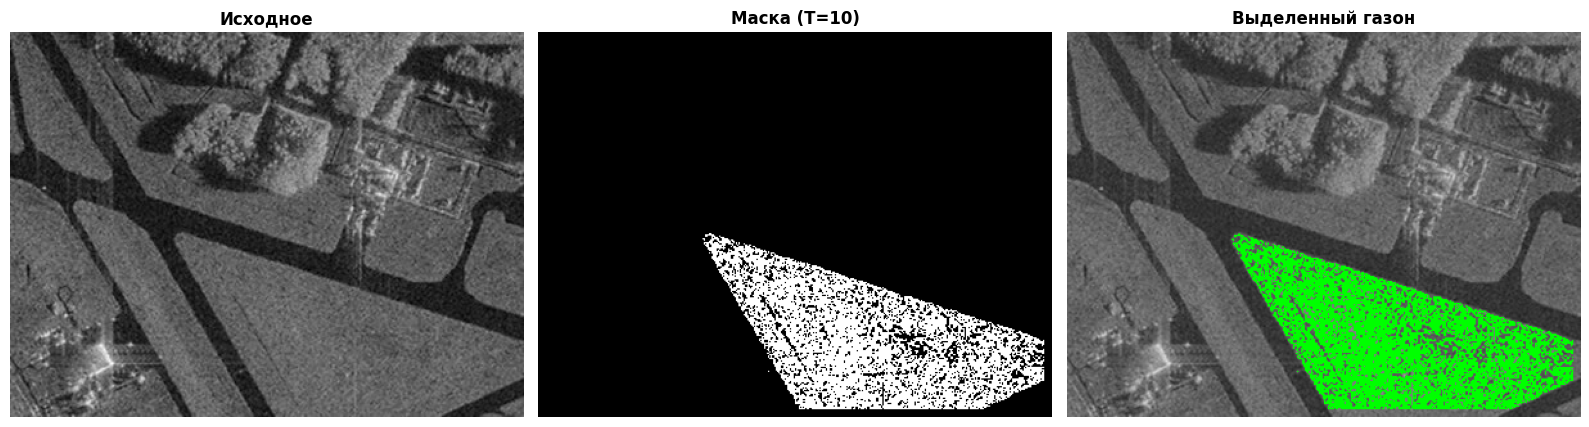

Площадь: 15407 пикселей


In [15]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

seed_point = (250, 250)
T = 10

print(f'Выделение газона: seed={seed_point}, T={T}')
mask = region_growing(image_gray, seed_point, homo_average, 6, T)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].imshow(image_gray, cmap='gray')
axes[0].set_title('Исходное', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title(f'Маска (T={T})', fontweight='bold')
axes[1].axis('off')

overlay = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR)
overlay[mask > 0] = [0, 255, 0]
axes[2].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
axes[2].set_title('Выделенный газон', fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()
print(f'Площадь: {np.count_nonzero(mask)} пикселей')

---
## Watershed для подсчета пальм

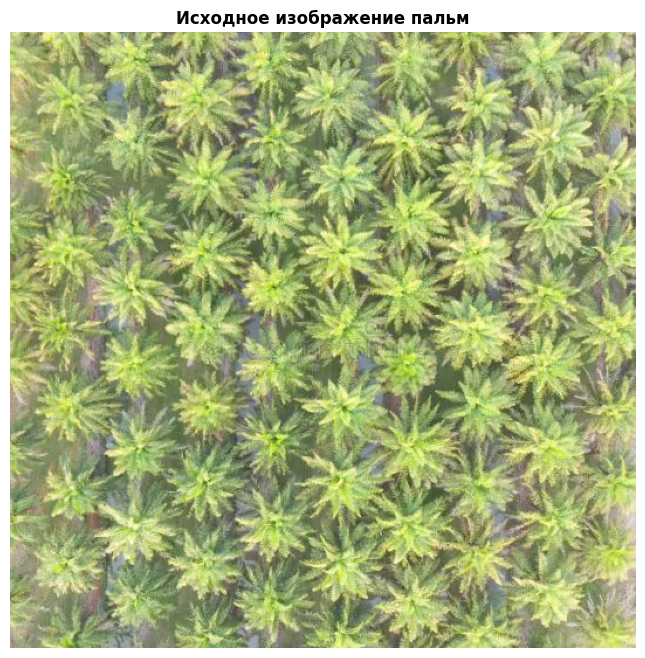

In [16]:
image_palm = cv2.imread('palm_1.JPG')
image_palm_gray = cv2.cvtColor(image_palm, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(image_palm, cv2.COLOR_BGR2RGB))
plt.title('Исходное изображение пальм', fontweight='bold')
plt.axis('off')
plt.show()

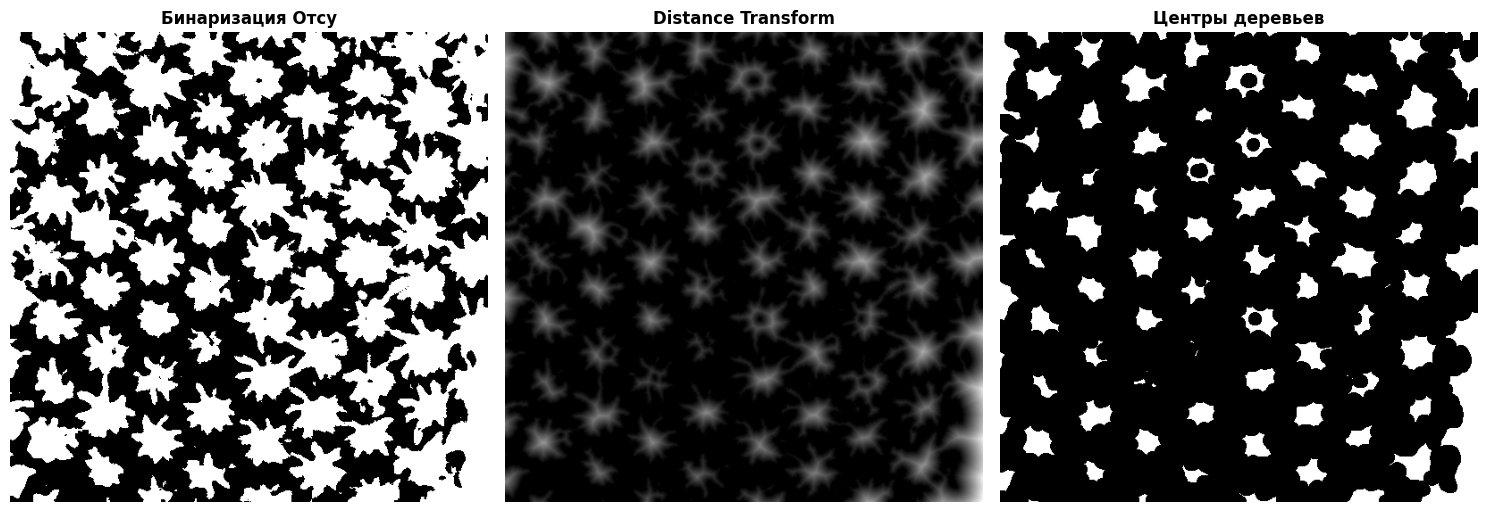

In [ ]:
palm_filtered = cv2.bilateralFilter(image_palm_gray, d=11, sigmaColor=75, sigmaSpace=75)

_, thresh = cv2.threshold(palm_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

_, sure_fg = cv2.threshold(dist, 0.2 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(thresh, cmap='gray')
axes[0].set_title('Бинаризация Отсу', fontweight='bold')
axes[1].imshow(dist, cmap='gray')
axes[1].set_title('Distance Transform', fontweight='bold')
axes[2].imshow(sure_fg, cmap='gray')
axes[2].set_title('Центры деревьев', fontweight='bold')
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()

Найдено центров (стартовых точек): 99


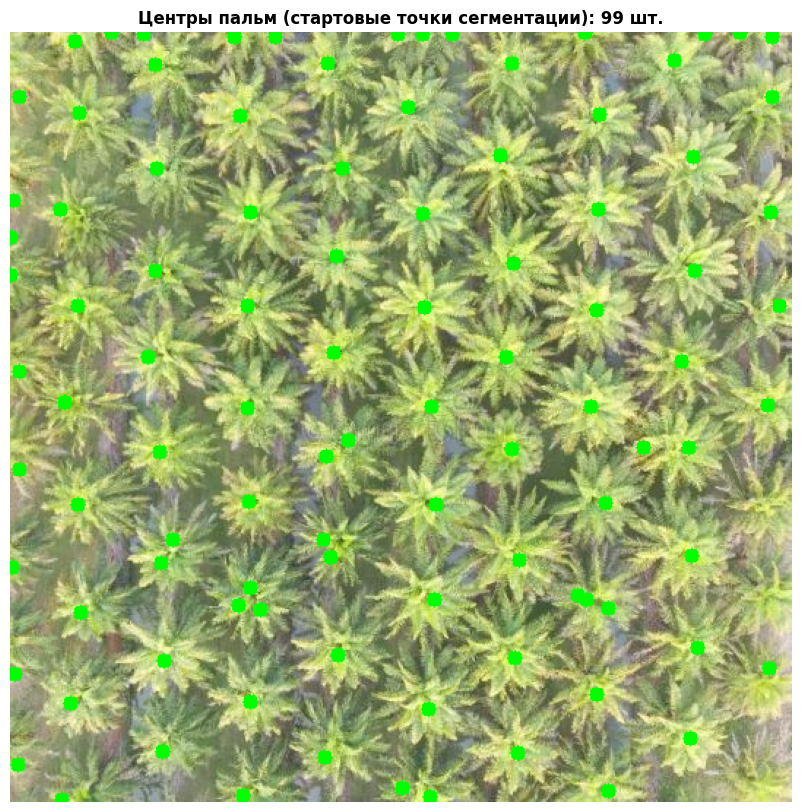

Зелёные точки — центры, от которых начинается сегментация каждой пальмы


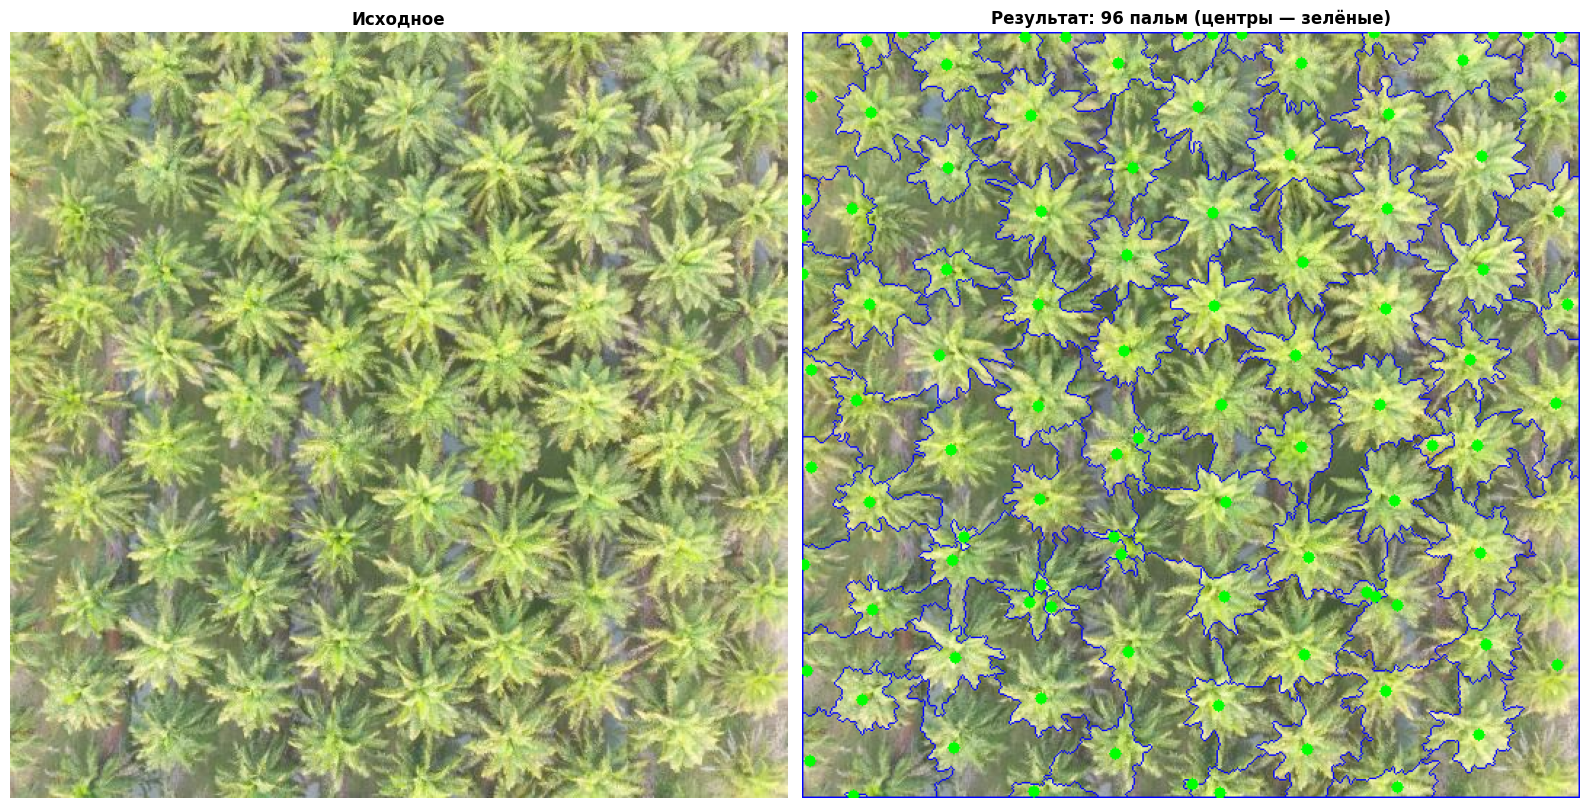

Обнаружено пальмовых деревьев: 96
Каждая зелёная точка — центр дерева, от которого Watershed сегментировал область


In [ ]:
_, markers = cv2.connectedComponents(sure_fg)
centers = []
for label in range(1, markers.max() + 1):
    pts = np.where(markers == label)
    if len(pts[0]) > 0:
        cy, cx = int(pts[0].mean()), int(pts[1].mean())
        centers.append((cx, cy))

print(f'Найдено центров (стартовых точек): {len(centers)}')

img_centers = image_palm.copy()
for cx, cy in centers:
    cv2.circle(img_centers, (cx, cy), 5, (0, 255, 0), -1)

plt.figure(figsize=(14, 10))
plt.imshow(cv2.cvtColor(img_centers, cv2.COLOR_BGR2RGB))
plt.title(f'Центры пальм (стартовые точки сегментации): {len(centers)} шт.', fontweight='bold')
plt.axis('off')
plt.show()

print('Зелёные точки — центры, от которых начинается сегментация каждой пальмы')

markers = cv2.watershed(image_palm, markers)

palm_count = len(np.unique(markers)) - 2

result = image_palm.copy()
result[markers == -1] = [255, 0, 0]

for cx, cy in centers:
    cv2.circle(result, (cx, cy), 4, (0, 255, 0), -1)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(cv2.cvtColor(image_palm, cv2.COLOR_BGR2RGB))
axes[0].set_title('Исходное', fontweight='bold')
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Результат: {palm_count} пальм (центры — зелёные)', fontweight='bold')
axes[1].axis('off')
plt.tight_layout()
plt.show()

print(f'Обнаружено пальмовых деревьев: {palm_count}')
print(f'Каждая зелёная точка — центр дерева, от которого Watershed сегментировал область')